# Classification exercise in HEP

## Example of KERAS-based DNN implementation of an LHC sarch analysis

It is inspired by the work shown in Baldi et al.
(https://arxiv.org/abs/1402.4735), and it uses as data samples the ones accompanying that paper, and available as

https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz

and

https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz.

## Definition of the physics problem

Each of the samples includes a large sample of simulated LHC events, chracterised by a well defined final state. 
For the HIGGS sample the final state is two jets coming from the fragmentation of two b-quarks, and the decay 
products of two W bosons. If we adress the case where one of the W decays into a lepton and a neutrino, and the 
other decays into two jets, we have four jets, 1 lepton and the measured imbalance of the momentum in the plane. 
For each of the jets/lepton the 4-momentum is stored in the datafiles, in the standard coordinate system used in 
collider experiments, and the two components on the of the tranverse momentum imbalance (MET), which represent 
a measurement of the two transverse components of the momentum of the neutrino which escapes detection.
Each event has a label 0 or 1, which will be named SIG, where 1 means that the event is a SIGNAL event, 
i.e. it was produced by the physical process we are trying to discover, and 0 means that the event is 
a BACKGROUND i.e. was produced by a known process, and we want to discard it. 


## Data loading

The provided samples are of several million events, in order to fit into the colab memory and to have a reasonable execution speed during the lecture we provide in dropbox reduced samples of 240k events. To further speed up execution the sample can be further reduced m

In [ ]:
#Load the dataset using pandas and numpy

import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt


higgsusy=1

print("higgsusy switch ",higgsusy)

if higgsusy==1:

  link='https://www.dropbox.com/s/muyqdaw17iqxlnd/susyred1.csv.gz?dl=1' 


  features=['SIG','lep_1_pT', 'lep_1_eta', 'lep_1_phi', 'lep_2_pT', 'lep_2_eta', 'lep_2_phi',
            'MET_val', 'MET_phi', 'MET_rel', 'axial_MET',  'MT2']        

  low_features=['lep_1_pT', 'lep_1_eta', 'lep_1_phi', 'lep_2_pT', 'lep_2_eta', 'lep_2_phi',
                'MET_val', 'MET_phi']

  high_features=['MET_rel', 'axial_MET', 'MT2']
                  
if higgsusy==2:

  link='https://www.dropbox.com/s/vdnstm4qo24uppn/higgsred.csv.gz?dl=1'
  
  features=['SIG','lepton_pT', 'lepton_eta', 'lepton_phi', 'MET_val', 'MET_phi', 
            'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 
            'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag', 
            'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

  low_features=['lepton_pT', 'lepton_eta', 'lepton_phi', 'MET_val', 'MET_phi', 
            'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 
            'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag']

  high_features=['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

# define number of records that we want to read
N = 240000
print("Size of dataset : %i"%N)
df = pd.read_csv(link, compression='gzip', header=None,nrows=N,engine='python')
#Name the columns using the 'features' array
df.columns=features
#Inspect contents
#print(df.head)
print ("data loaded")

## Data preparation

Once we have loaded the data, we need to define the input vector X, including all of the columns except the label one, and the target vector including only the label.

Since we are going for anomaly detection, we split at this level the SM (bg, SIG==0) on which we will train the 
autoencoder, and the anomaly (sig, SIG==1) on which we will benchmark the performance of the autoencoder

In [ ]:

df_bgf=df.query("SIG==0")
df_sig=df.query("SIG==1")
df_bg = df_bgf[[col for col in df_bgf.columns if col!="SIG"]]
label_standard = df_bgf['SIG'].values
df_sig = df_sig[[col for col in df_sig.columns if col!="SIG"]]

### Split training and test samples

We split only the signal sample into a test and a train sample, and we further split away a 10% of the training events to be used for monitoring the optimisation

In [ ]:
from sklearn.model_selection import train_test_split
X_learn, X_test, label_learn, label_test = train_test_split(df_bg, label_standard, test_size=0.2)
print(X_learn.shape, X_test.shape, label_learn.shape, label_test.shape)
X_train, X_val, label_train, label_val = train_test_split(X_learn, label_learn, test_size=0.1)
print(X_train.shape, X_val.shape, label_train.shape, label_val.shape, label_test.shape)
del df_bg, df_bgf, label_standard, X_learn, label_learn

### Scaling of features to have average one

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # initialise StandardScaler

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_trains = scaler.transform(X_train)
X_tests = scaler.transform(X_test)
X_vals = scaler.transform(X_val)
df_sigs = scaler.transform(df_sig)

## Create the autoencoder

In [ ]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

nvar=X_trains.shape[1]
#---------
# Encoder
#---------
inputLayer = Input(shape=nvar)
#
enc = Dense(100)(inputLayer)
enc = Activation('elu')(enc)
#
enc = Dense(50)(inputLayer)
enc = Activation('elu')(enc)
#
enc = Dense(5)(enc)
enc = Activation('elu')(enc)

#---------
# Decoder
#---------
dec = Dense(50)(enc)
dec = Activation('elu')(dec)
#
dec = Dense(100)(enc)
dec = Activation('elu')(dec)
#
dec = Dense(nvar)(dec)
autoencoder = Model(inputs=inputLayer, outputs=dec)

autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

## Train the autoencoder

In [ ]:
batch_size = 128
n_epochs = 300

history = autoencoder.fit(X_trains, X_trains, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_vals, X_vals),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

In [ ]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## Run prediction on test Standard Model (background)  sample and on full anomaly (signal) sample

In [ ]:
predictedQCD = autoencoder.predict(X_tests)
predicted_anomaly = autoencoder.predict(df_sigs)

## Calculate losses

In [ ]:
def mse(data_in, data_out):
    print(data_in.shape)
    print(data_out.shape)
    mse = (data_out-data_in)*(data_out-data_in)
    print(mse.shape)
    # sum over features
    mse = mse.sum(1)
    print(mse.shape)
    return mse

lossQCD = mse(X_tests, predictedQCD)
loss_anomaly=mse(df_sigs, predicted_anomaly)

## Plot them for Standard Model

In [ ]:
maxScore = np.max(lossQCD)

plt.hist(lossQCD, bins=100, label='Standard Model', density=True, range=(0, maxScore),
         histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

## Compare losses for Standard Model and Anomaly

In [ ]:
import math
maxScore=np.max(loss_anomaly)
minScore=np.min(np.log(lossQCD))
plt.hist(np.log(lossQCD), bins=100, label='Standard Model', density=True, range=(minScore, math.log(maxScore)),
         histtype='step', fill=False, linewidth=1.5)
plt.hist(np.log(loss_anomaly), bins=100, label='Anomaly', density=True, range=(minScore, math.log(maxScore)),
            histtype='step', fill=False, linewidth=1.5)
#plt.hist(lossQCD, bins=100, label='ttbar', density=True, range=(0, maxScore),
#         histtype='step', fill=False, linewidth=1.5)
#plt.hist(loss_anomaly, bins=100, label='Heavy Higgs', density=True, range=(0, maxScore),
#            histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("log(AE Loss)")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

## Calculate and plot ROC and AUC

In [ ]:
from sklearn.metrics import roc_curve, auc
plt.figure()
# set SM label at zero
targetQCD = np.zeros(lossQCD.shape[0])
target_anomaly=np.ones(loss_anomaly.shape[0])
print(loss_anomaly.shape, targetQCD.shape)
trueVal = np.concatenate((target_anomaly,targetQCD))
predVal = np.concatenate((loss_anomaly,lossQCD))
print(trueVal.shape, predVal.shape)
fpr, tpr, threshold = roc_curve(trueVal,predVal)
auc1= auc(fpr, tpr)
plt.plot(fpr,tpr,label='Anomaly Detection, auc = %.1f%%'%(auc1*100.))
#plt.semilogy()
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.grid(True)
plt.legend(loc='lower right')
plt.show()


Compare for SUSY model AUC obtained with supervised  DNN

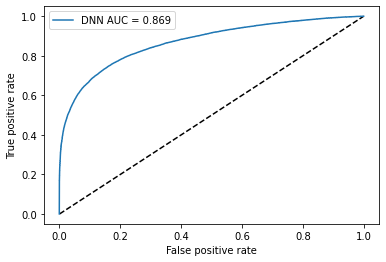